# Merging existing datasets

Two or more datasets may be merged together to form a new, enlargened dataset.

In [1]:
%matplotlib notebook

import numpy as np

from qcodes import Station
from qcodes.dataset.database import initialise_database
from qcodes.dataset.experiment_container import new_experiment
from qcodes.dataset.measurements import Measurement
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import new_data_set

## Setting up instruments

We pretend to be changing some gate voltages and measuring conductivity

In [2]:
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
lockin = DummyInstrument('lockin', gates=['g'])
lockin.g.unit = 'arb. un.'

station = Station(dac, lockin)

We set up some gaussian functions to simulate an "interesting" conductivity landscape.

In [3]:
def gaussian(x0, sigma, x):
    return np.exp((-(x-x0)**2)/(2*sigma**2))/(np.sqrt(2*np.pi*sigma**2))


def landscape(x, y):
    sigma_xs = [0.9, .4, 1]
    sigma_ys = [0.6, 2, 0.5]
    x0s = [0, -1, 1]
    y0s = [0, -1, 1]
    signs = [-1, 1, 1]
    
    value = 0
    for sx, sy, x0, y0, sign in zip(sigma_xs, sigma_ys, x0s, y0s, signs):
        value += sign*gaussian(x0, sx, x)*gaussian(y0, sy, y)
        
    return value


def conductance_space():
    x = dac.ch1.get()
    y = dac.ch2.get()
    
    return landscape(x, y)
    
lockin.g.get = conductance_space

## Measurement 1

In a first measurement, we sweep out the voltage region from -1 to 0 on both axes with a resolution of 10 mV on each axis.

In [4]:
meas = Measurement()
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(lockin.g,
                        setpoints=[dac.ch1, dac.ch2])

with meas.run() as datasaver:
    for v1 in np.linspace(-2, 0, 100):
        dac.ch1(v1)
        for v2 in np.linspace(-2, 0, 100):
            dac.ch2(v2)
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (lockin.g, lockin.g()))
dsid1 = datasaver.run_id

Starting experimental run with id: 201


<IPython.core.display.Javascript object>


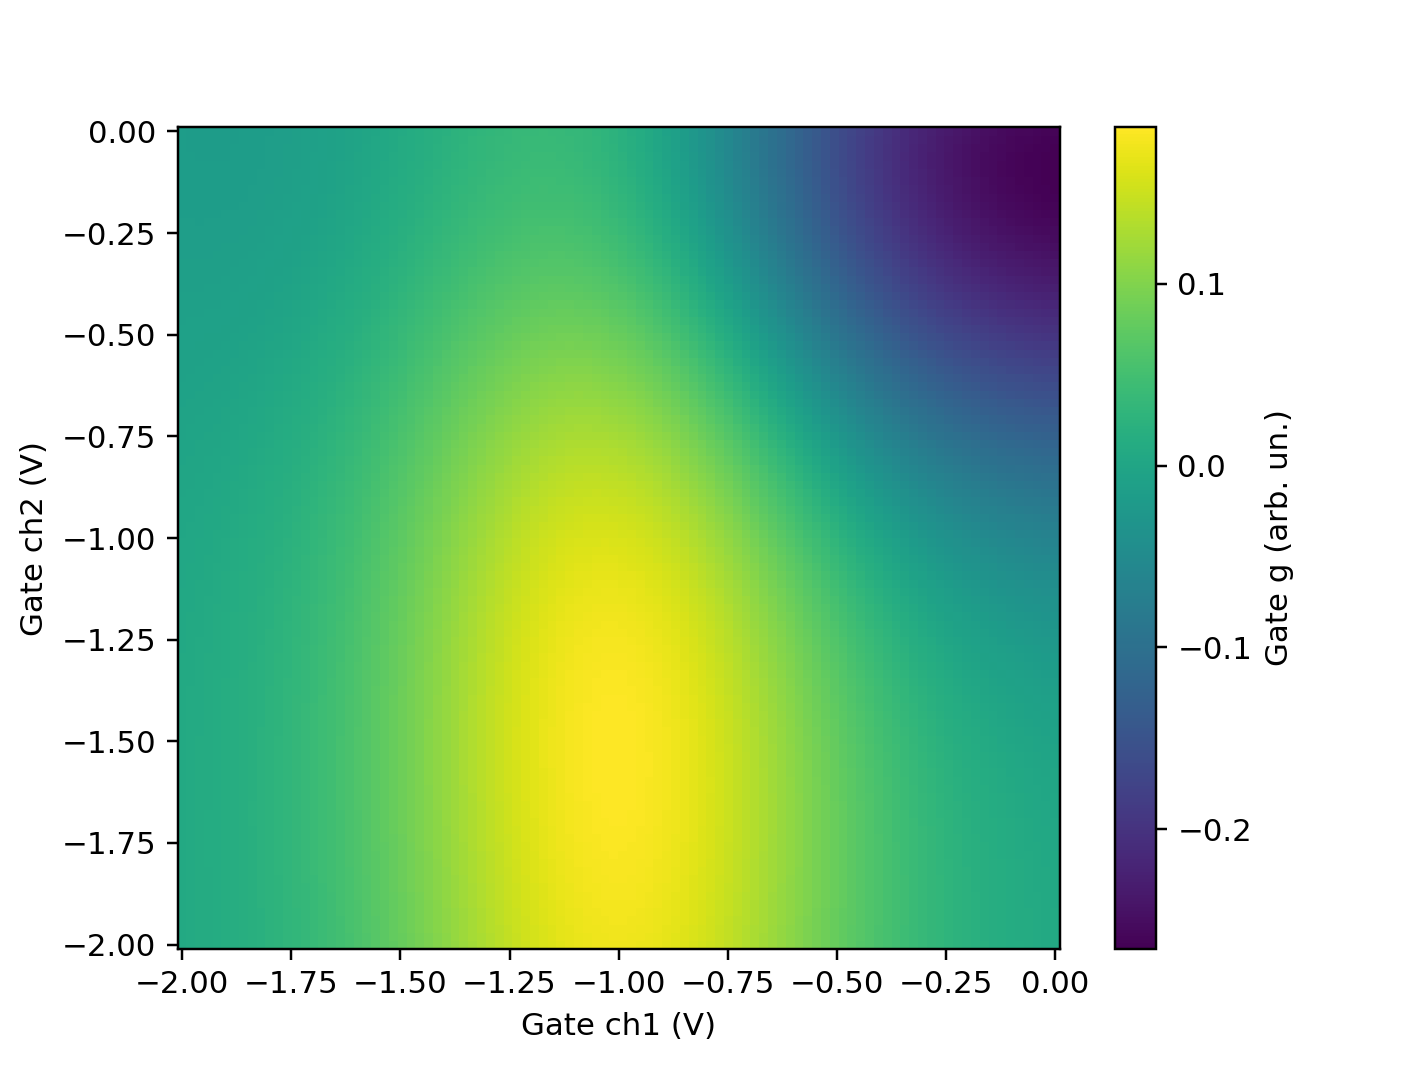

([<matplotlib.axes._subplots.AxesSubplot at 0x263bc29b4e0>],
 [<matplotlib.colorbar.Colorbar at 0x263bc201278>])

In [5]:
plot_by_id(dsid1)

## Measurement 2

Deciding that the data look interesting, we continue with a similar sweep on the other side of the origin.


In [6]:
with meas.run() as datasaver:
    for v1 in np.linspace(0, 2, 100):
        for v2 in np.linspace(0, 2, 100):
            dac.ch2(v2)
            datasaver.add_result((dac.ch1, v1),
                                 (dac.ch2, v2),
                                 (lockin.g, lockin.g()))
            
dsid2 = datasaver.run_id

Starting experimental run with id: 202


<IPython.core.display.Javascript object>


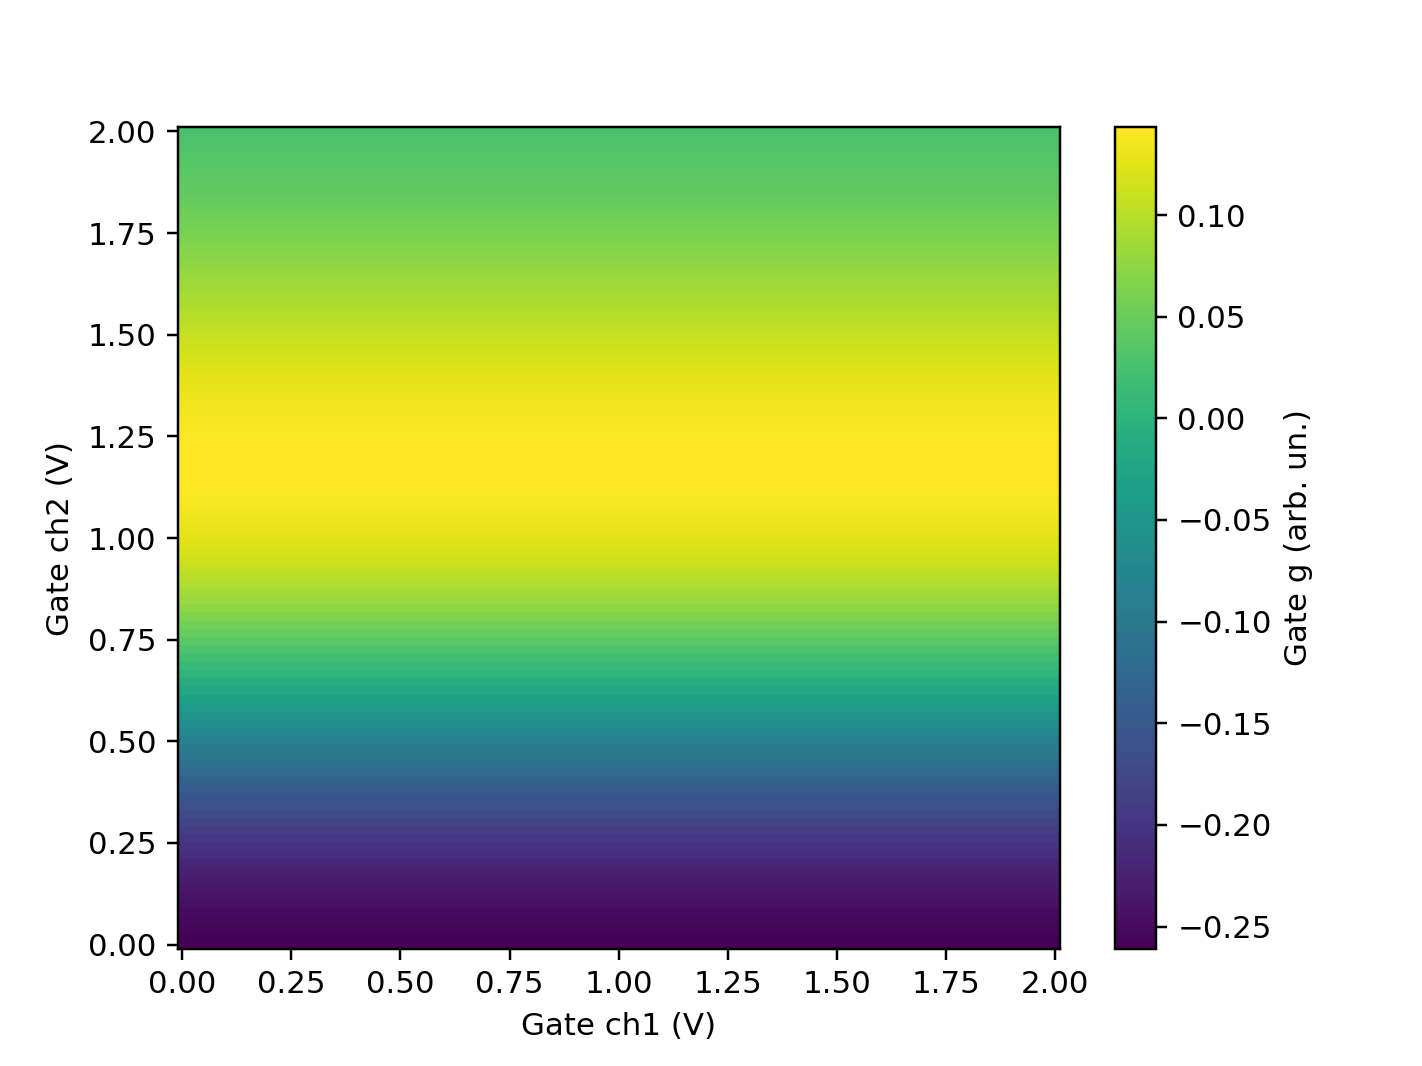

([<matplotlib.axes._subplots.AxesSubplot at 0x263ab36cf98>],
 [<matplotlib.colorbar.Colorbar at 0x263bc345ba8>])

In [7]:
plot_by_id(dsid2)

## Measurement 3

To make sure that we can handle semi-odd things, let's make a new measurement with the same parameters, but added in a different order and also sweep a domain with a hole in it.

In [8]:
meas = Measurement()
meas.register_parameter(dac.ch1)
meas.register_parameter(dac.ch2)
meas.register_parameter(lockin.g,
                        setpoints=[dac.ch2, dac.ch1])


def allowed_region(v1, v2) -> bool:
    okay = True
    if 1.2 > v1 > 0.3 and -0.5 < v2 < -0.25:
        okay = False
    return okay


with meas.run() as datasaver:
    for v1 in np.linspace(0.2, 1.5, 120):
        dac.ch1(v1)
        for v2 in np.linspace(-1.5, -.2, 150):
            if not allowed_region(v1, v2):
                continue
            else:
                dac.ch2(v2)
                datasaver.add_result((dac.ch1, v1),
                                     (dac.ch2, v2),
                                     (lockin.g, lockin.g()))
dsid3 = datasaver.run_id

Starting experimental run with id: 203


<IPython.core.display.Javascript object>


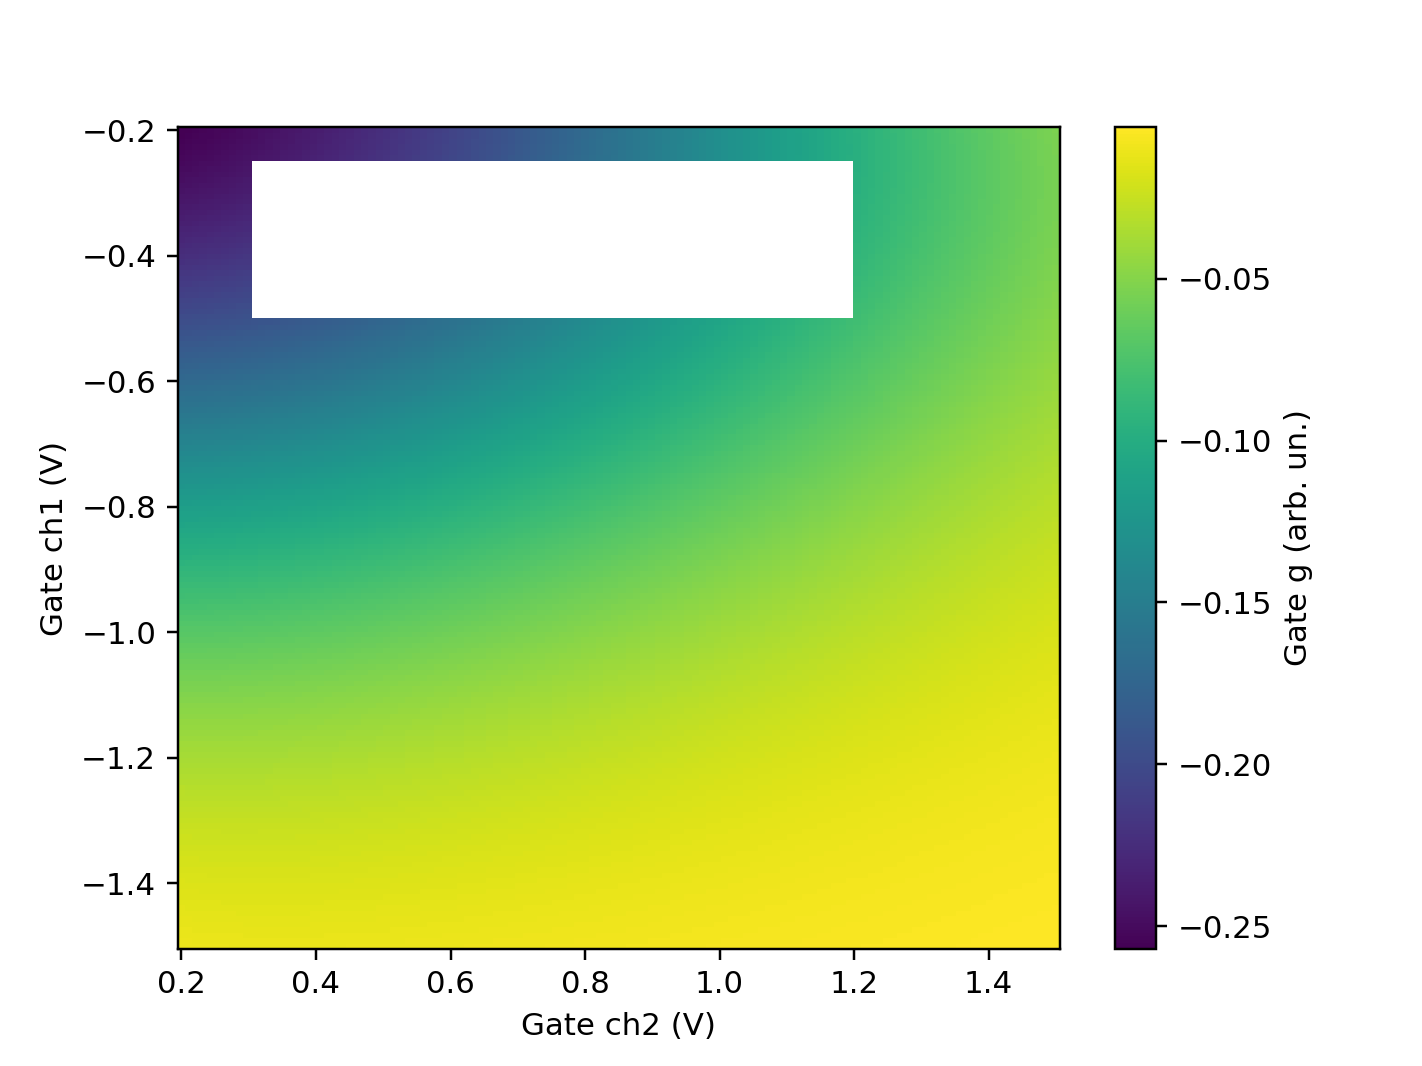

([<matplotlib.axes._subplots.AxesSubplot at 0x263bc356f98>],
 [<matplotlib.colorbar.Colorbar at 0x263bc2fe9b0>])

In [9]:
plot_by_id(dsid3)

## Combining the measurements

We can merge any number of datasets together and plot them back using `plot_by_id`

In [10]:
from qcodes.dataset.data_set_tools import merge
from qcodes.dataset.data_set import load_by_id

merged_ds = merge([dsid1, dsid2])


<IPython.core.display.Javascript object>


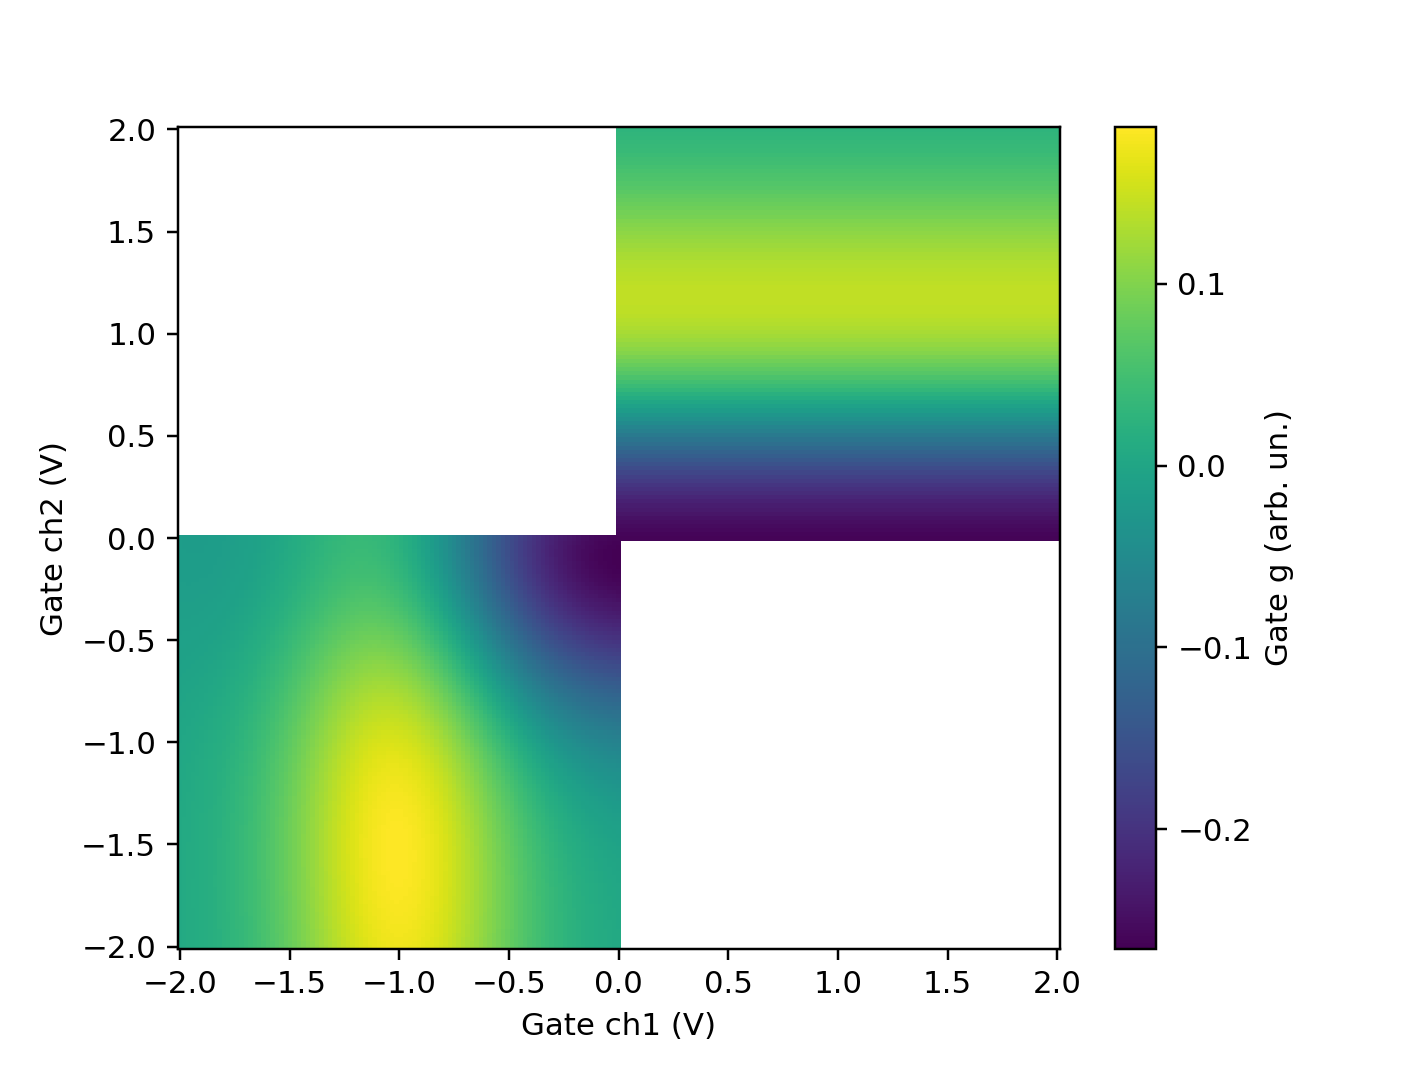

([<matplotlib.axes._subplots.AxesSubplot at 0x263bc23b160>],
 [<matplotlib.colorbar.Colorbar at 0x263c1308e80>])

In [11]:
plot_by_id(merged_ds.run_id)

<IPython.core.display.Javascript object>


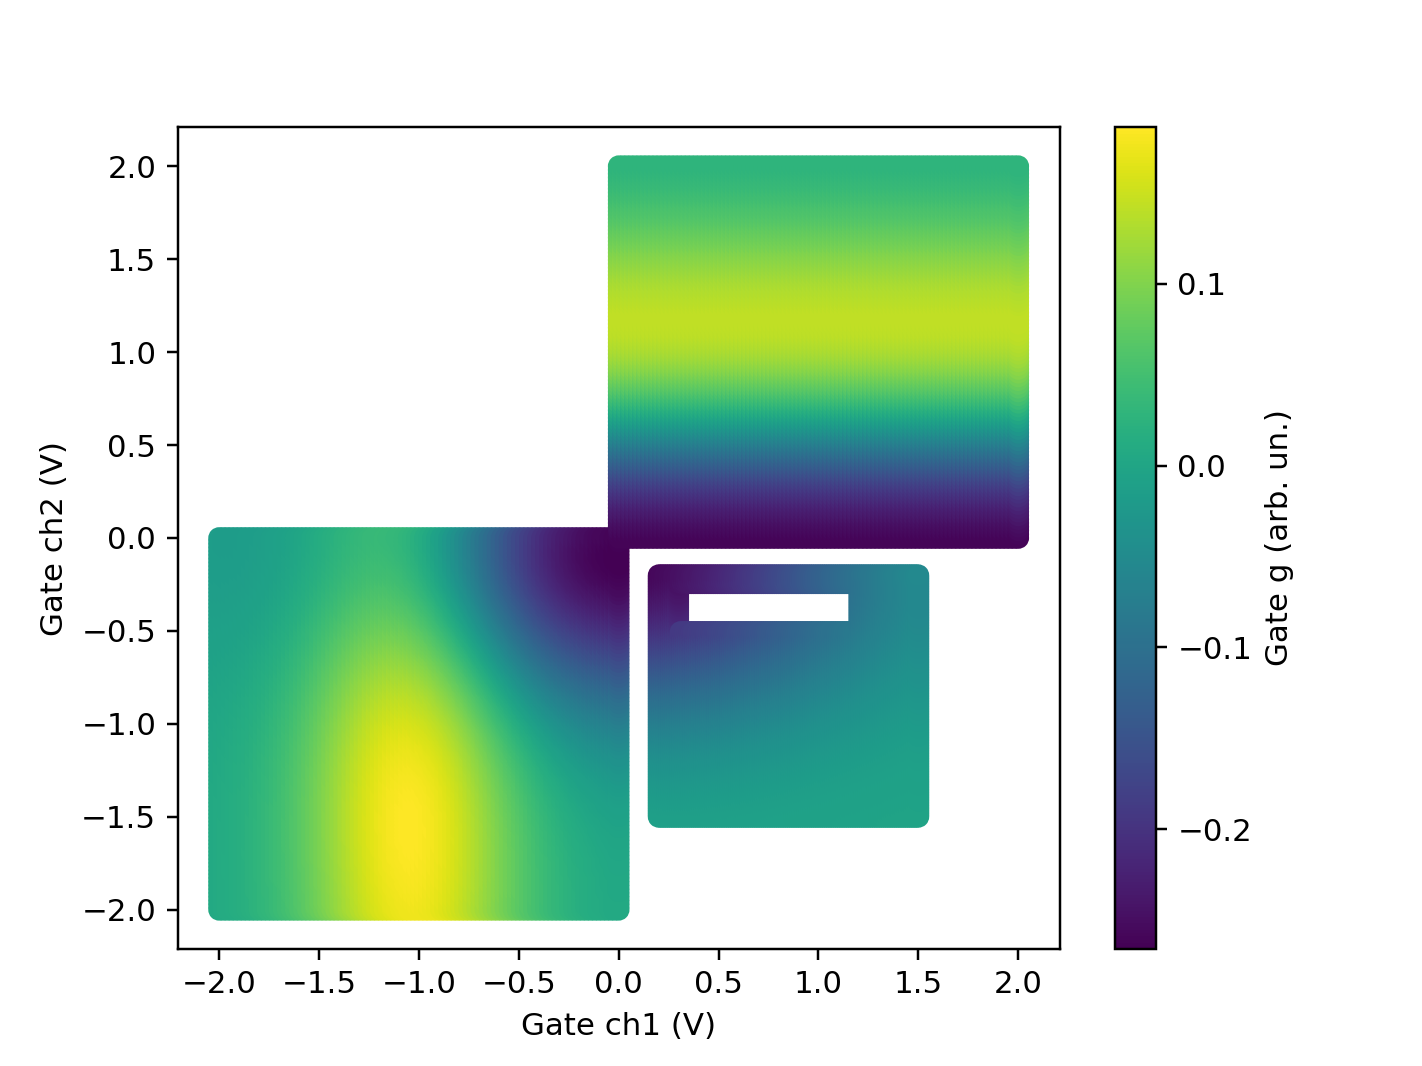

([<matplotlib.axes._subplots.AxesSubplot at 0x263c12709b0>],
 [<matplotlib.colorbar.Colorbar at 0x263c21240f0>])

In [12]:
fully_merged_ds = merge([dsid1, dsid2, dsid3])
plot_by_id(fully_merged_ds.run_id)

## Snapshots

The snapshots of the original (parent) datasets are automatically put into the merged datasets under the tag `parent_snapshots`.

In [13]:
import json

str_dict = fully_merged_ds.get_metadata('parent_snapshots')
snapshot_dict = json.loads(str_dict)

The `snapshot_dict` has string keys (the `run_id` of the parents) and the snapshots as values.

In [14]:
print(list(snapshot_dict.keys()))

['201', '202', '203']


In [15]:
snapshot_dict['201']

{'station': {'instruments': {'dac': {'functions': {},
    'submodules': {},
    '__class__': 'qcodes.tests.instrument_mocks.DummyInstrument',
    'parameters': {'IDN': {'value': {'vendor': None,
       'model': 'dac',
       'serial': None,
       'firmware': None},
      'ts': '2018-08-01 15:33:18',
      'raw_value': {'vendor': None,
       'model': 'dac',
       'serial': None,
       'firmware': None},
      '__class__': 'qcodes.instrument.parameter.Parameter',
      'full_name': 'dac_IDN',
      'post_delay': 0,
      'label': 'IDN',
      'vals': '<Anything>',
      'name': 'IDN',
      'instrument': 'qcodes.tests.instrument_mocks.DummyInstrument',
      'instrument_name': 'dac',
      'unit': '',
      'inter_delay': 0},
     'ch1': {'value': 0,
      'ts': '2018-08-01 15:33:18',
      'raw_value': 0,
      '__class__': 'qcodes.instrument.parameter.Parameter',
      'full_name': 'dac_ch1',
      'post_delay': 0,
      'label': 'Gate ch1',
      'vals': '<Numbers -800<=v<=400>',
